In [ ]:
!nvidia-smi

In [ ]:
!pip install tensorflow_io
import tensorflow_io

In [ ]:
!pip install git+https://github.com/tensorflow/docs
import tensorflow_docs.vis.embed as embed

In [ ]:
import tensorflow.python.ops.numpy_ops.np_config as np_config
np_config.enable_numpy_behavior()

In [ ]:
from google.colab.patches import cv2_imshow
from IPython import display 
import glob
from PIL import Image
import imageio
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras, ones_like, zeros_like, GradientTape
from tensorflow import nn, convert_to_tensor
from tensorflow.random import set_seed, normal
import tensorflow_datasets as tfds
#from keras.preprocessing.image import ImageDataGenerator
#from keras.preprocessing import image_dataset_from_directory

from keras.models import Sequential
from keras.layers import Conv2DTranspose, Dense, LeakyReLU, BatchNormalization, Reshape, Conv2D, Flatten
from keras.activations import tanh, relu
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

In [ ]:
device = tf.test.gpu_device_name()

In [ ]:
with tf.device('/device:GPU:0'):
  (ds_train, ds_val), info = tfds.load('lsun', split=['train', 'validation'], shuffle_files=True, with_info=True)

In [ ]:
info

In [ ]:
examples = ds_train.take(100000)

In [ ]:
for sample in examples:
  image = sample['image'].numpy()
  print(image.shape)
  plt.imshow(image[:,:,:].astype(np.uint8))
  plt.show()

In [ ]:
resized = []
for sample in examples:
  image = sample['image'].numpy()
  resized.append(cv2.resize(image, (64, 64), interpolation = cv2.INTER_AREA))
resized = np.array(resized)

In [ ]:
cv2_imshow(resized[1])

In [ ]:
train_images = resized.reshape(resized.shape[0], 64, 64, 3).astype('float32') #maybe try larger size images

In [ ]:
BUFFER_SIZE = train_images.shape[0]
BATCH_SIZE = 128

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

#**MNIST (Practice Stuff)**

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
resized = []
for i in range(len(train_images)):
  resized.append(cv2.resize(train_images[i], (64,64), interpolation = cv2.INTER_AREA))
resized = np.array(resized)
resized = resized #[0:10000]

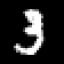

In [ ]:
cv2_imshow(resized[10])
cv2_imshow(train_images[10])

In [ ]:
train_images = resized.reshape(resized.shape[0], 64, 64, 1).astype('float32') # last is 3 for rgb images
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [ ]:
BUFFER_SIZE = train_images.shape[0] #size of dataset
BATCH_SIZE = 32 #128

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

#**Generator**

In [ ]:
def make_generator():
  model = Sequential()
  model.add(Dense(4*4*1024, use_bias = False, input_shape = (100, )))
  model.add(BatchNormalization())
  #model.add(LeakyReLU())
                                 
  model.add(Reshape((4,4,1024)))
  assert model.output_shape == (None, 4, 4, 1024)
  
  model.add(Conv2DTranspose(512, (5,5), padding='same', strides=(2,2), use_bias=False, activation='relu'))
  assert model.output_shape == (None, 8, 8, 512)  
  model.add(BatchNormalization())
  #model.add(LeakyReLU())

  model.add(Conv2DTranspose(256, (5, 5), padding='same', strides=(2,2), use_bias=False, activation='relu'))
  assert model.output_shape == (None, 16, 16, 256)
  model.add(BatchNormalization())
 # model.add(LeakyReLU())

  model.add(Conv2DTranspose(128, (5, 5), padding='same', strides=(2,2), use_bias=False, activation='relu'))
  assert model.output_shape == (None, 32, 32, 128)
  model.add(BatchNormalization())
 # model.add(LeakyReLU()) 

  model.add(Conv2DTranspose(1, (5, 5), padding='same', strides=(2,2), use_bias=False, activation='tanh')) #MAKE 1 3 Later
  assert model.output_shape == (None, 64, 64, 1) #MAKE 1 3 LATER

  return model

In [ ]:
generator = make_generator()

In [ ]:
noise = normal([1,100])
gen_image = generator(noise, training=False)

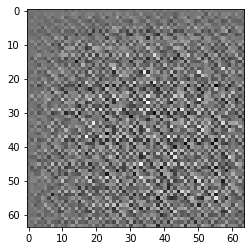

In [ ]:
plt.imshow(gen_image[0, :, :, 0], cmap='gray')

#**Discriminator**

In [ ]:
def make_discriminator():
  model = Sequential()
  model.add(Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape = [64,64,1])) #MAKE 1 3 LATER
  model.add(BatchNormalization())
  model.add(LeakyReLU(.2))

  model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(.2))

  model.add(Conv2D(256, (5,5), strides = (2,2), padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(.2))

  model.add(Conv2D(512, (5,5), strides=(2,2), padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(.2))

  model.add(Flatten())
  model.add(Dense(1))

  return model

In [ ]:
discriminator = make_discriminator()
print(discriminator(gen_image))

tf.Tensor([[0.00010038]], shape=(1, 1), dtype=float32)


#**Loss & Optimizers**

In [ ]:
BCE_loss = BinaryCrossentropy(from_logits=True) # Helper function

###**Discriminator Loss**

In [ ]:
def discriminator_loss(real_out, fake_out):
  real_loss = BCE_loss(ones_like(real_out), real_out) # Compare discrim output from real image to array of 1s
  fake_loss = BCE_loss(zeros_like(fake_out), fake_out) # Compare discrim output from fake image to array of 0s
  total_loss = real_loss + fake_loss
  return total_loss

###**Generator Loss**

In [ ]:
def generator_loss(fake_out):
  total_loss = BCE_loss(ones_like(fake_out), fake_out)
  return total_loss

###**Optimizers**

In [ ]:
generator_optimizer = Adam(learning_rate = .0002, beta_1 = .5)
discriminator_optimizer = Adam(learning_rate = .0002, beta_1 = .5)

In [ ]:
EPOCHS = 50 #increase later
noise_dim = 100
num_generate = 16 #16

seed = normal([num_generate, noise_dim])

In [ ]:
@tf.function
def train_step(images):
  noise = normal([BATCH_SIZE, noise_dim])

  with GradientTape() as disc_tape, GradientTape() as gen_tape:
    gen_images = generator(noise, training = True)

    real_out = discriminator(images, training = True)
    fake_out = discriminator(gen_images, training = True)

    gen_loss = generator_loss(fake_out)
    disc_loss = discriminator_loss(real_out, fake_out)

  generator_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
  discriminator_grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator.trainable_variables))

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training = False)

  fig = plt.figure(figsize = (4,4)) #2,2

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1) # 2,2
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray') # * 127.5 + 127.5, cmap='gray' #make 0 : for color
    plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
def train(data, epochs):
  for epoch in range(epochs):
    print(epoch)
    for image_batch in data:
      train_step(image_batch)
    
    display.clear_output(wait = True)
    generate_and_save_images(generator, epoch + 1, seed)

  display.clear_output(wait = True)
  generate_and_save_images(generator, epochs, seed)

In [ ]:
with tf.device('/device:GPU:0'):
  train(train_dataset, EPOCHS)

In [ ]:
def display_image(epoch_no):
  return Image.open('image_at_epoch_{04d}.png'.format(epoch_no))

In [ ]:
ani_file = 'dcgan.gif'

with imageio.get_writer(ani_file, mode = 'I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


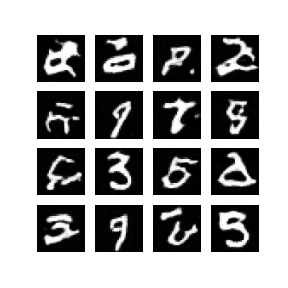

In [ ]:
embed.embed_file(ani_file)